In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
!pip install featurewiz
!pip install featurewiz --upgrade
from featurewiz import featurewiz as FW
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 kB 546.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 67.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 8.0.0
    Uninstalling pyarrow-8.0.0:
      Successfully uninstalled pyarrow-8.0.0
  Attempting uninstall: networkx
    Found existing installation: networkx 2.5
    Uninstalling networkx-2.5:
      Successfully uninstalled networkx-2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
tfx-bsl 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 7.0.0 which is incompatible.
tfx-bsl 1.9.0 req

Imported 0.2.03 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



# DATA PREPROCESSING
Let's read in the training dataset into a dataframe using pandas and take a look at a summary of what it consists of

In [3]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Now let's do the same for the test dataset

In [4]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


We can see we have missing values in the age, fare and embarked columns so we need to clean this up first.

The following is a nice function written by @SIVA HEMANG that replaces the age and fare null values with their respective medians when grouped by Pclass and sex.

As there are only 2 samples in the training dataset with missing embarked features we can afford to omit these from the dataset.

In [5]:
def cleanData(data):
    
    # Data missing Case2
    data['Age'] = data.groupby(['Pclass','Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
    
    # FARE Data missing in test
    data['Fare'] = data.groupby(['Pclass','Sex'])['Fare'].transform(lambda x: x.fillna(x.median()))

    # Data missing Case3
    data.dropna(axis=0, subset=['Embarked'], inplace=True)
    
    return data

Create clean training and testing data using the above function and take a look at a summary of them both to verify all null vaules have been dealt with

In [6]:
clean_train = cleanData(train_data)
clean_test = cleanData(test_data)

In [7]:
clean_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Cabin        202 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 90.3+ KB


In [8]:
clean_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 39.2+ KB


Looks good :-)

Now let's choose our feature columns. I don't think passengerID, name, ticket or cabin would be predictive of survival so I am going to choose Pclass, sex, age, sibsp, parch, fare and embarked and one hot encode the sex and embarked columns.

 I will perform this on both training and test datasets and check the summary info to verify this has all worked as expected.

In [9]:
clean_train = clean_train.drop(["PassengerId", "Name", "Ticket", "Cabin"],1)
clean_train = pd.get_dummies(clean_train)
clean_train

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,0,1,0,0,1
887,1,1,19.0,0,0,30.0000,1,0,0,0,1
888,0,3,21.5,1,2,23.4500,1,0,0,0,1
889,1,1,26.0,0,0,30.0000,0,1,1,0,0


In [10]:
clean_test = clean_test.drop(["PassengerId", "Name", "Ticket", "Cabin"],1)
clean_test= pd.get_dummies(clean_test)
clean_test

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,34.5,0,0,7.8292,0,1,0,1,0
1,3,47.0,1,0,7.0000,1,0,0,0,1
2,2,62.0,0,0,9.6875,0,1,0,1,0
3,3,27.0,0,0,8.6625,0,1,0,0,1
4,3,22.0,1,1,12.2875,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
413,3,24.0,0,0,8.0500,0,1,0,0,1
414,1,39.0,0,0,108.9000,1,0,1,0,0
415,3,38.5,0,0,7.2500,0,1,0,0,1
416,3,24.0,0,0,8.0500,0,1,0,0,1


# FEATURE SELECTION
Now let's create interaction features, remove highly correlated variables using the SULOV method and then apply recursive XGBoost feature selection. Both these steps are performed as implemented in Featurewiz

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Correlation Limit = 0.8
Skipping category encoding since no category encoders specified in input...
#### Single_Label Binary_Classification problem ####
    Loaded train data. Shape = (889, 11)
#### Single_Label Binary_Classification problem ####
loading the entire test dataframe - there is no nrows limit applicable #########
    Loaded test data. Shape = (418, 10)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
####################################################################################

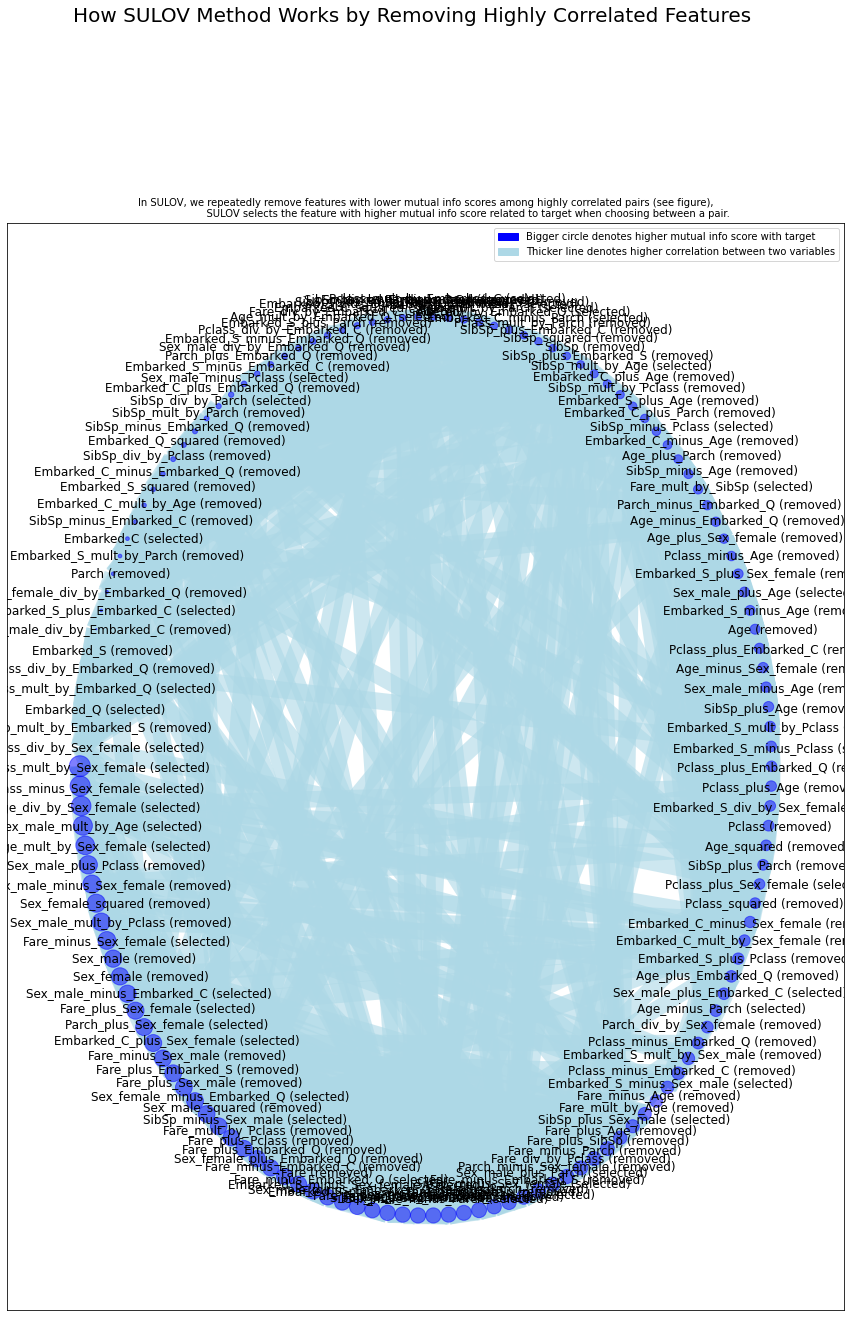

Time taken for SULOV method = 2 seconds
    Adding 0 categorical variables to reduced numeric variables  of 105
Finally 105 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Since ['interactions'] category encoding is done, dropping original categorical vars from predictors...
Current number of predictors before recursive XGBoost = 105 
    Taking top 30 features per iteration...
    XGBoost version using 1.6.2 as tree method: hist
Number of booster rounds = 100
        using 105 variables...
            selecting 14 features in this iteration
            Time taken for regular XGBoost feature selection = 0 seconds
        using 84 variables...
            selec

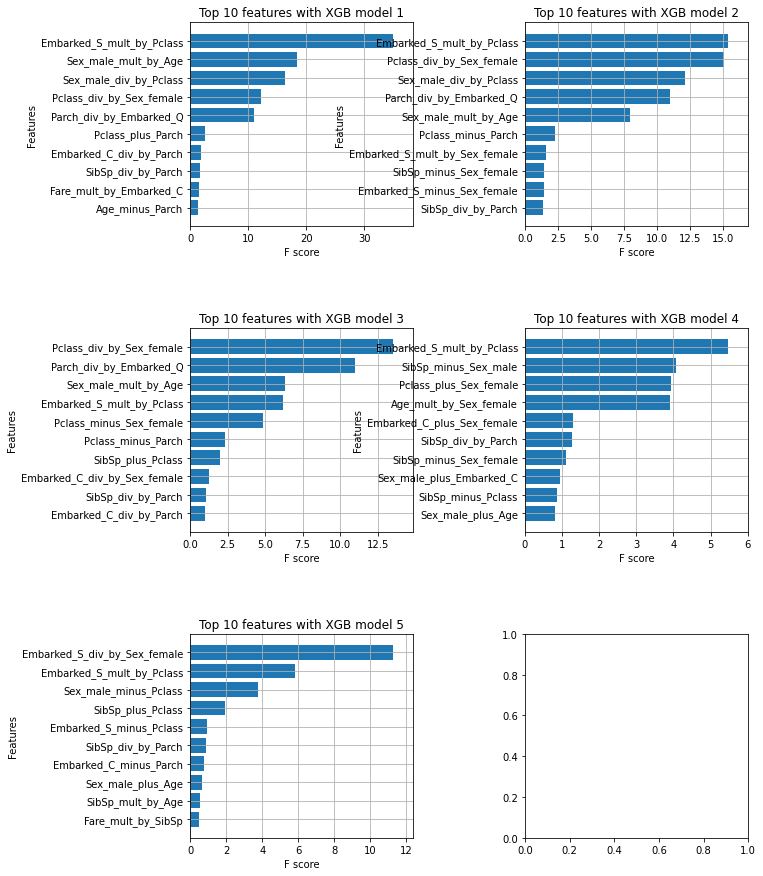

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 19 important features:
['Embarked_S_mult_by_Pclass', 'Sex_male_mult_by_Age', 'Sex_male_div_by_Pclass', 'Pclass_div_by_Sex_female', 'Parch_div_by_Embarked_Q', 'Pclass_plus_Parch', 'Embarked_C_div_by_Parch', 'SibSp_div_by_Parch', 'Fare_mult_by_Embarked_C', 'Age_minus_Parch', 'Fare_div_by_Sex_female', 'Fare_mult_by_Parch', 'Fare_div_by_SibSp', 'SibSp_div_by_Sex_female', 'Pclass_minus_Parch', 'Embarked_S_mult_by_Sex_female', 'SibSp_minus_Sex_male', 'Pclass_plus_Sex_female', 'Embarked_S_div_by_Sex_female']
Total Time taken for featurewiz selection = 4 seconds
Output contains two dataframes: train and test with 19 important features.


In [11]:
train_select, test_select = FW(clean_train, "Survived", corr_limit=0.8, verbose=2, sep=",", 
                     header=0, test_data=clean_test, feature_engg="interactions", category_encoders="")


We've been left with 14 "important" features. Finally we need to seperate out our dataframes into x train, y train and x test sets

In [12]:
train_select = train_select.dropna(1)
X_train_select = train_select.drop("Survived", 1)
y_train = train_select["Survived"]
X_test_select = test_select.dropna(1)

# MODEL TRAINING
Finally, let's train some models and see which one works best with it's "out of the box" default hyperparameters

I'll be using 5 fold cross validation on the whole training dataset and assessing performance using the best mean CV accuracy score for each of the following models:

* Decision Tree
* Random Forest
* K Nearest Neighbors
* Logistic Regression
* Gradient Boosting classifier
* EXtreme Gradient Boosting classifier

In [13]:
DT_model = DecisionTreeClassifier()
DT_scores = cross_val_score(DT_model, X_train_select, y_train, cv=5)
print(DT_scores)
print(DT_scores.mean())
print(DT_scores.std())

[0.7752809  0.80337079 0.80898876 0.81460674 0.79661017]
0.7997714721005523
0.013621899767725976


In [14]:
RF_model = RandomForestClassifier()
RF_scores = cross_val_score(RF_model, X_train_select, y_train, cv=5)
print(RF_scores)
print(RF_scores.mean())
print(RF_scores.std())

[0.74719101 0.80337079 0.80337079 0.82022472 0.79661017]
0.7941534945724624
0.024743224457575586


In [15]:
KNN_model = KNeighborsClassifier()
KNN_scores = cross_val_score(KNN_model, X_train_select, y_train, cv=5)
print(KNN_scores)
print(KNN_scores.mean())
print(KNN_scores.std())

[0.75280899 0.75842697 0.76966292 0.74157303 0.79661017]
0.763816415920777
0.01873280315998285


In [16]:
LogReg_model = LogisticRegression()
LogReg_scores = cross_val_score(LogReg_model, X_train_select, y_train, cv=5)
print(LogReg_scores)
print(LogReg_scores.mean())
print(LogReg_scores.std())

[0.78089888 0.80898876 0.81460674 0.79775281 0.84180791]
0.8088110201231512
0.020118590884729736


In [17]:
GB_model = GradientBoostingClassifier()
GB_scores = cross_val_score(GB_model, X_train_select, y_train, cv=5)
print(GB_scores)
print(GB_scores.mean())
print(GB_scores.std())

[0.81460674 0.81460674 0.84269663 0.82022472 0.81920904]
0.8222687742017394
0.010471398051769712


In [18]:
XGB_model = XGBClassifier()
XGB_scores = cross_val_score(XGB_model, X_train_select, y_train, cv=5)
print(XGB_scores)
print(XGB_scores.mean())
print(XGB_scores.std())

[0.76404494 0.81460674 0.84269663 0.80898876 0.83615819]
0.8132990541484162
0.027687591583794115


# MODEL TUNING
The gradient boosting classifier won!

Now I want to tune this model using its optimal selected features to see if I can improve it's accuracy.

I will use exhaustive gridsearch on the following 3 hyperparameters:

1. Loss function used
1. Number of estimators
1. Maximum depth

Each permutation of these hyperparameters will be assessed using 5 fold cross validation as before for consistency

In [19]:
param_grid={'loss' : ["log_loss", "deviance", "exponential"], 
                         'n_estimators' : range(1, 150), 
                         'max_depth' : range(1, 8)}
                        
grid = GridSearchCV(estimator=GB_model, param_grid = param_grid, 
                    refit = "true", verbose =1, n_jobs=-1)
grid.fit(X_train_select, y_train)
print("\n Best parameters are: " +str(grid.best_params_))
print("\n Best score is: " +str(grid.best_score_))

Fitting 5 folds for each of 3129 candidates, totalling 15645 fits

 Best parameters are: {'loss': 'deviance', 'max_depth': 5, 'n_estimators': 16}

 Best score is: 0.8369389957468419


In [20]:
GB_scores_tuned = cross_val_score(grid.best_estimator_, X_train_select, y_train, cv=5)
print(GB_scores_tuned)
print(GB_scores_tuned.mean())
print(GB_scores_tuned.std())

[0.78651685 0.83707865 0.82022472 0.83146067 0.87570621]
0.8301974227131341
0.028731321479639645


In [21]:
predictions = grid.predict(X_test_select)

In [22]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
